In [1]:
from naglmbis.models import load_charge_model
from openff.toolkit.topology import Molecule
import time
from interruptingcow import timeout

/Users/localadmin/miniforge3/envs/naglmbis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/localadmin/miniforge3/envs/naglmbis/lib/python3.11/site-packages/polars/meta/build.py:5: UserWarning: Polars binary is missing!
  from polars._utils.polars_version import get_polars_version


In [2]:
charge_model_esp= 'nagl-gas-charge-dipole-esp-wb-default'
gas_charge_dipole_esp_model = load_charge_model(charge_model_esp)

In [3]:
charge_model_esp= 'nagl-gas-charge-dipole-esp-wb-default'
gas_charge_dipole_esp_model = load_charge_model(charge_model_esp)

number_of_atoms = []
am1_bcc_times = []
nagl_mbis_times = []
start_molecule = 'C'
for i in range(25):
    #am1bcc
    print(f'am1bcc charges for {start_molecule}')
    molecule = Molecule.from_smiles(start_molecule, hydrogens_are_explicit=False)
    molecule.generate_conformers(n_conformers=1)
    start_time = time.perf_counter()
    try:
        molecule.assign_partial_charges(
            partial_charge_method='am1bcc',
            strict_n_conformers=1
        )
    except Exception as e:  # Catch all exceptions for debugging
        print(f"Exception occurred: {type(e).__name__} - {e}")
        molecule.assign_partial_charges(
            partial_charge_method="am1bcc",
            use_conformers=molecule.conformers,
        )
    end_time = time.perf_counter()
    number_of_atoms.append(molecule.n_atoms)
    am1_bcc_times.append(abs(start_time-end_time))
    #naglmbis
    print(f'naglmbis charges for {start_molecule}')
    rdkit_mol = molecule.to_rdkit()
    start_time = time.perf_counter()
    predicted_charges = gas_charge_dipole_esp_model.compute_properties(rdkit_mol)["mbis-charges"]
    end_time = time.perf_counter()
    nagl_mbis_times.append(abs(start_time-end_time))
    start_molecule = start_molecule+'C'
    


am1bcc charges for C
Exception occurred: ValueError - No registered toolkits can provide the capability "assign_partial_charges" for args "()" and kwargs "{'molecule': Molecule with name '' and SMILES '[H][C]([H])([H])[H]', 'partial_charge_method': 'am1bcc', 'use_conformers': None, 'strict_n_conformers': 1, 'normalize_partial_charges': True, '_cls': <class 'openff.toolkit.topology.molecule.Molecule'>}"
Available toolkits are: [ToolkitWrapper around The RDKit version 2024.09.4, ToolkitWrapper around Built-in Toolkit version None]
 ToolkitWrapper around The RDKit version 2024.09.4 <class 'openff.toolkit.utils.exceptions.ChargeMethodUnavailableError'> : partial_charge_method 'am1bcc' is not available from RDKitToolkitWrapper. Available charge methods are {'mmff94': {}, 'gasteiger': {}}
 ToolkitWrapper around Built-in Toolkit version None <class 'openff.toolkit.utils.exceptions.ChargeMethodUnavailableError'> : Partial charge method "am1bcc"" is not supported by the Built-in toolkit. Availa

ValueError: No registered toolkits can provide the capability "assign_partial_charges" for args "()" and kwargs "{'molecule': Molecule with name '' and SMILES '[H][C]([H])([H])[H]', 'partial_charge_method': 'am1bcc', 'use_conformers': [<Quantity([[ 0.00511871 -0.0106205   0.00601428]
 [ 0.54966796  0.75543841 -0.59698119]
 [ 0.7497641  -0.5879439   0.58528463]
 [-0.58675256 -0.65213582 -0.67609162]
 [-0.71779821  0.4952618   0.6817739 ]], 'angstrom')>], 'strict_n_conformers': False, 'normalize_partial_charges': True, '_cls': <class 'openff.toolkit.topology.molecule.Molecule'>}"
Available toolkits are: [ToolkitWrapper around The RDKit version 2024.09.4, ToolkitWrapper around Built-in Toolkit version None]
 ToolkitWrapper around The RDKit version 2024.09.4 <class 'openff.toolkit.utils.exceptions.ChargeMethodUnavailableError'> : partial_charge_method 'am1bcc' is not available from RDKitToolkitWrapper. Available charge methods are {'mmff94': {}, 'gasteiger': {}}
 ToolkitWrapper around Built-in Toolkit version None <class 'openff.toolkit.utils.exceptions.ChargeMethodUnavailableError'> : Partial charge method "am1bcc"" is not supported by the Built-in toolkit. Available charge methods are {'zeros': {'rec_confs': 0, 'min_confs': 0, 'max_confs': 0}, 'formal_charge': {'rec_confs': 0, 'min_confs': 0, 'max_confs': 0}}


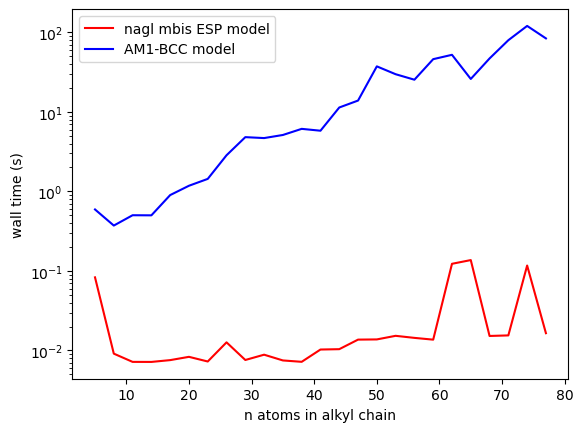

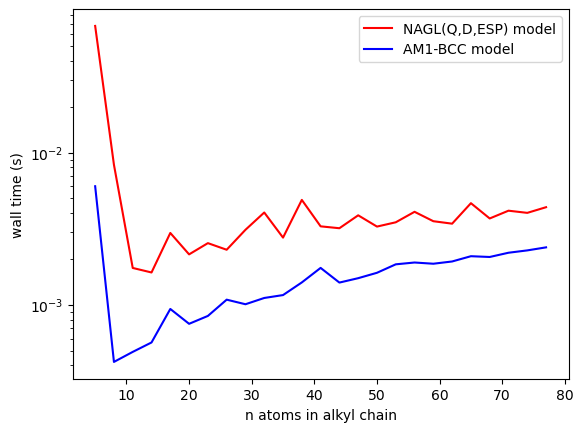

In [ ]:
import matplotlib.pyplot as plt
plt
plt.plot(number_of_atoms,nagl_mbis_times, color='red', label='NAGL(Q,D,ESP) model')
plt.plot(number_of_atoms,am1_bcc_times, color='blue', label='AM1-BCC model')
plt.yscale('log')
plt.xlabel('n atoms in alkyl chain')
plt.ylabel('wall time (s)')
plt.legend()
plt.savefig('AM1BCCvsNagl.png',dpi=300)
plt.show()


In [ ]:
start_molecule ='C(C)(=O)NC(C)C(=O)NC'
frag = 'C(C)(=O)NC(C)'
end_frag ='C(=O)NC'

number_of_atoms = []
am1_bcc_times = []
nagl_mbis_times = []
for i in range(200):
    #am1bcc
    print(f'am1bcc charges for {start_molecule}')
    molecule = Molecule.from_smiles(start_molecule, allow_undefined_stereo=True)
    molecule.generate_conformers(n_conformers=1)
    start_time = time.perf_counter()
    molecule.assign_partial_charges('am1bcc', use_conformers=molecule.conformers, strict_n_conformers=1)
    end_time = time.perf_counter()
    number_of_atoms.append(molecule.n_atoms)
    am1_bcc_times.append(abs(start_time-end_time))
    #naglmbis
    print(f'naglmbis charges for {start_molecule}')
    rdkit_mol = molecule.to_rdkit()
    start_time = time.perf_counter()
    try:
        with timeout(1000, exception=RuntimeError):
            predicted_charges = gas_charge_dipole_esp_model.compute_properties(rdkit_mol)["mbis-charges"]
            end_time = time.perf_counter()
            total_time = abs(start_time-end_time)
    except RuntimeError:
        total_time = 1000
    nagl_mbis_times.append(total_time)
    
    frag = frag + 'C(C)'
    start_molecule = frag + end_frag

am1bcc charges for C(C)(=O)NC(C)C(=O)NC


ValueError: No registered toolkits can provide the capability "assign_partial_charges" for args "()" and kwargs "{'molecule': Molecule with name '' and SMILES '[H][N]([C](=[O])[C]([H])([N]([H])[C](=[O])[C]([H])([H])[H])[C]([H])([H])[H])[C]([H])([H])[H]', 'partial_charge_method': 'am1bcc', 'use_conformers': [<Quantity([[ 2.37002541e+00 -3.64716280e-02 -5.10654313e-01]
 [ 3.65705387e+00  4.45715510e-01  4.39966952e-02]
 [ 2.28530484e+00 -3.14268155e-01 -1.72493254e+00]
 [ 1.27590467e+00 -1.57510290e-01  4.00545105e-01]
 [-1.94216590e-03 -6.20484029e-01 -7.46011148e-02]
 [-4.90121673e-01 -1.86119757e+00  6.14452180e-01]
 [-9.72280554e-01  4.87025799e-01  1.40214064e-01]
 [-5.60184687e-01  1.56703596e+00  6.60824853e-01]
 [-2.31290384e+00  2.72764008e-01 -2.51410499e-01]
 [-3.26688062e+00  1.33596929e+00 -5.03118612e-02]
 [ 4.01790226e+00 -1.92276775e-01  8.73034600e-01]
 [ 3.51488813e+00  1.46364005e+00  4.74124874e-01]
 [ 4.39853333e+00  5.93838016e-01 -7.69847432e-01]
 [ 1.35388780e+00  7.72120320e-02  1.41772984e+00]
 [ 4.42886695e-02 -8.30063083e-01 -1.14046415e+00]
 [-1.55304080e+00 -2.00372394e+00  3.21653591e-01]
 [ 1.63627481e-02 -2.77714041e+00  2.34725542e-01]
 [-4.65863669e-01 -1.79006420e+00  1.71936736e+00]
 [-2.65951750e+00 -6.13730483e-01 -6.80678000e-01]
 [-3.21506438e+00  1.77571518e+00  9.69083967e-01]
 [-4.31005410e+00  9.86865028e-01 -2.12097542e-01]
 [-3.12629773e+00  2.19114970e+00 -7.54853271e-01]], 'angstrom')>], 'strict_n_conformers': 1, 'normalize_partial_charges': True, '_cls': <class 'openff.toolkit.topology.molecule.Molecule'>}"
Available toolkits are: [ToolkitWrapper around The RDKit version 2024.09.4, ToolkitWrapper around Built-in Toolkit version None]
 ToolkitWrapper around The RDKit version 2024.09.4 <class 'openff.toolkit.utils.exceptions.ChargeMethodUnavailableError'> : partial_charge_method 'am1bcc' is not available from RDKitToolkitWrapper. Available charge methods are {'mmff94': {}, 'gasteiger': {}}
 ToolkitWrapper around Built-in Toolkit version None <class 'openff.toolkit.utils.exceptions.ChargeMethodUnavailableError'> : Partial charge method "am1bcc"" is not supported by the Built-in toolkit. Available charge methods are {'zeros': {'rec_confs': 0, 'min_confs': 0, 'max_confs': 0}, 'formal_charge': {'rec_confs': 0, 'min_confs': 0, 'max_confs': 0}}
